In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
sys.path.append('../')

In [7]:
from tensorflow.keras import models

In [3]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, recall_score, precision_score

In [13]:
df_test = pd.read_csv("../preprocessing/processed_data/dftest.csv")
data = np.load('../preprocessing/processed_data/segmented_slices.npz')
X_test0=data['X_test0']
X_test1=data['X_test1']
X_test2=data['X_test2']
y_test=data['y_test']
trained_model = models.load_model("../models/best_model/")

In [15]:
y_probs = trained_model.predict([X_test0, X_test1, X_test2])

2022-09-09 13:47:20.110326: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-09 13:47:20.362905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
y_pred = (y_probs+0.1).round() #threshold is 0.4
df_test["y_test"] = y_test
df_test["y_probs"] = y_probs
df_test["y_pred"] = y_pred
df_test.to_csv("./predictions/img_cnn_predictions.csv")

In [22]:
print(confusion_matrix(df_test["y_test"], df_test["y_pred"]))
print("Accucary is ", accuracy_score(df_test["y_test"], df_test["y_pred"]))
print("Recall is ", recall_score(df_test["y_test"], df_test["y_pred"]))
print("Precision is ", precision_score(df_test["y_test"], df_test["y_pred"]))

[[4 2]
 [1 3]]
Accucary is  0.7
Recall is  0.75
Precision is  0.6


In [19]:
df_test[df_test["label"] != df_test["y_test"]]

,ID,Sex,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,...,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,y_test,y_probs,y_pred


In [26]:
df_num[df_]

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,Imputed,ID,Sex,label,Train,y_test_num,y_pred_num,probs1_num,classification
0,73.0,39367.0,6146.0,850330.0,3707.0,0.0,114_S_0416,F,0,False,0,1,0.75,FP
1,73.0,40800.0,5702.0,915118.0,3339.0,0.0,023_S_1247,F,1,False,1,1,0.67,TP
2,88.0,79554.0,5338.0,958537.0,3317.0,0.0,128_S_1088,M,1,False,1,1,0.61,TP
3,76.0,23794.0,6918.6,924107.0,3651.6,1.0,126_S_0784,F,1,False,1,1,0.77,TP
4,87.0,59530.0,6326.2,945561.0,3577.4,1.0,141_S_0697,M,1,False,1,1,0.67,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,77.0,33503.0,5471.0,788112.0,3256.0,0.0,099_S_0352,F,0,False,0,1,0.78,FP
200,79.0,29915.0,6813.0,928173.0,4048.0,0.0,027_S_0116,M,0,False,0,1,0.64,FP
201,72.0,44550.0,5683.0,975848.0,2535.0,0.0,128_S_0740,M,0,False,0,1,0.76,FP
202,83.0,29096.0,5946.0,959442.0,3688.0,0.0,021_S_0626,M,1,False,1,1,0.60,TP


In [27]:
df_num = pd.read_csv("../modelling/tables/numerical_brian_only_predictions.csv")
df_result = df_result.merge(df, on="ID", how="left")
df_num = df_result.merge(df_num, on="ID", how="inner")
df_result= df_result[["ID", "Age", "label", "y_test", "y_pred", "dataset", "Sex"]]

In [28]:
df_result[df_result["dataset"] == "ADNI"]

,ID,Age,label,y_test,y_pred,dataset,Sex
109,114_S_0416,73,CN,0,0.724675,ADNI,F
110,023_S_1247,73,MCI,1,0.903095,ADNI,F
111,128_S_1088,88,MCI,1,0.688217,ADNI,M
112,126_S_0784,76,AD,1,0.653371,ADNI,F
113,141_S_0697,87,MCI,1,0.702664,ADNI,M
...,...,...,...,...,...,...,...
312,099_S_0352,77,CN,0,0.554856,ADNI,F
313,027_S_0116,79,MCI,1,0.217359,ADNI,M
314,128_S_0740,72,AD,1,0.891688,ADNI,M
315,021_S_0626,83,MCI,1,0.630802,ADNI,M


In [29]:
df_num.dropna(subset=['Imputed'],inplace=True, axis=0)
df_num

,Unnamed: 0,ID,y_test,y_pred,Sex_x,Age_x,Educ,SES,MMSE,CDR,...,WholeBrain,Entorhinal,Imputed,Sex_y,label_y,Train,y_test_num,y_pred_num,probs1_num,classification
0,109,114_S_0416,0,0.724675,F,73,NaN,NaN,NaN,NaN,...,850330.0,3707.0,0.0,F,0,False,0,1,0.75,FP
1,110,023_S_1247,1,0.903095,F,73,NaN,NaN,NaN,NaN,...,915118.0,3339.0,0.0,F,1,False,1,1,0.67,TP
2,111,128_S_1088,1,0.688217,M,88,NaN,NaN,NaN,NaN,...,958537.0,3317.0,0.0,M,1,False,1,1,0.61,TP
3,112,126_S_0784,1,0.653371,F,76,NaN,NaN,NaN,NaN,...,924107.0,3651.6,1.0,F,1,False,1,1,0.77,TP
4,113,141_S_0697,1,0.702664,M,87,NaN,NaN,NaN,NaN,...,945561.0,3577.4,1.0,M,1,False,1,1,0.67,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,312,099_S_0352,0,0.554856,F,77,NaN,NaN,NaN,NaN,...,788112.0,3256.0,0.0,F,0,False,0,1,0.78,FP
200,313,027_S_0116,1,0.217359,M,79,NaN,NaN,NaN,NaN,...,928173.0,4048.0,0.0,M,0,False,0,1,0.64,FP
201,314,128_S_0740,1,0.891688,M,72,NaN,NaN,NaN,NaN,...,975848.0,2535.0,0.0,M,0,False,0,1,0.76,FP
202,315,021_S_0626,1,0.630802,M,83,NaN,NaN,NaN,NaN,...,959442.0,3688.0,0.0,M,1,False,1,1,0.60,TP


In [30]:
df_num["ensemble"] = (df_num["y_pred"] + df_num["probs1_num"]) /2

In [31]:
df_num["end_pred"] = (df_num["ensemble"]+0).round()
df_num["cnn_pred"] = (df_num["y_pred"]+0).round()

In [32]:
df_num[df_num["end_pred"] != df_num["cnn_pred"]]

,Unnamed: 0,ID,y_test,y_pred,Sex_x,Age_x,Educ,SES,MMSE,CDR,...,Sex_y,label_y,Train,y_test_num,y_pred_num,probs1_num,classification,ensemble,end_pred,cnn_pred
9,118,067_S_0098,1,0.563289,F,84,NaN,NaN,NaN,NaN,...,F,1,False,1,0,0.38,FN,0.471644,0.0,1.0
31,140,023_S_1104,1,0.444016,F,65,NaN,NaN,NaN,NaN,...,F,1,False,1,1,0.83,TP,0.637008,1.0,0.0
46,155,023_S_0030,1,0.399449,F,80,NaN,NaN,NaN,NaN,...,F,1,False,1,1,0.85,TP,0.624725,1.0,0.0
50,159,022_S_0543,1,0.588124,F,72,NaN,NaN,NaN,NaN,...,F,1,False,1,0,0.40,FN,0.494062,0.0,1.0
51,160,116_S_0890,1,0.232317,F,60,NaN,NaN,NaN,NaN,...,F,1,False,1,1,0.95,TP,0.591158,1.0,0.0
55,164,051_S_1072,1,0.444615,F,60,NaN,NaN,NaN,NaN,...,F,1,False,1,1,0.69,TP,0.567308,1.0,0.0
94,204,067_S_0019,0,0.317742,F,73,NaN,NaN,NaN,NaN,...,F,0,False,0,1,0.73,FP,0.523871,1.0,0.0
108,218,057_S_0818,0,0.340506,F,74,NaN,NaN,NaN,NaN,...,F,0,False,0,1,0.66,FP,0.500253,1.0,0.0
116,227,126_S_0506,0,0.391297,F,72,NaN,NaN,NaN,NaN,...,F,1,False,1,1,0.70,TP,0.545649,1.0,0.0
122,233,021_S_0276,1,0.289040,M,71,NaN,NaN,NaN,NaN,...,M,0,False,0,1,0.87,FP,0.579520,1.0,0.0


In [33]:
# before ensemble
print(confusion_matrix(df_num["y_test"], df_num["cnn_pred"]))
print(accuracy_score(df_num["y_test"], df_num["cnn_pred"]))
print(recall_score(df_num["y_test"], df_num["cnn_pred"]))
print(precision_score(df_num["y_test"], df_num["cnn_pred"]))

[[ 12  45]
 [ 13 134]]
0.7156862745098039
0.9115646258503401
0.7486033519553073


In [36]:
#after ensemble
print(confusion_matrix(df_num["y_test"], df_num["end_pred"]))
print(accuracy_score(df_num["y_test"], df_num["end_pred"]))
print(recall_score(df_num["y_test"], df_num["end_pred"]))
print(precision_score(df_num["y_test"], df_num["end_pred"]))

[[  5  52]
 [  8 139]]
0.7058823529411765
0.9455782312925171
0.7277486910994765


In [37]:
df_result["prediction"] = (df_result["y_pred"]+0.1).round()

In [38]:
df_result

,ID,Age,label,y_test,y_pred,dataset,Sex,prediction
0,OAS1_0145_MR1,34,CN,0,0.002277,OASIS,M,0.0
1,OAS1_0019_MR1,89,CN,0,0.605508,OASIS,F,1.0
2,OAS1_0372_MR1,59,CN,0,0.006064,OASIS,M,0.0
3,OAS1_0018_MR1,39,CN,0,0.001319,OASIS,M,0.0
4,OAS1_0266_MR1,51,CN,0,0.060436,OASIS,M,0.0
...,...,...,...,...,...,...,...,...
312,099_S_0352,77,CN,0,0.554856,ADNI,F,1.0
313,027_S_0116,79,MCI,1,0.217359,ADNI,M,0.0
314,128_S_0740,72,AD,1,0.891688,ADNI,M,1.0
315,021_S_0626,83,MCI,1,0.630802,ADNI,M,1.0


In [40]:
def classification(row):
    if (row.y_test == 1) & (row .prediction == 1):
        return "TP"
    if (row.y_test == 0) & (row .prediction == 1):
        return "FP"
    if (row.y_test == 0) & (row .prediction == 0):
        return "TN"
    if (row.y_test == 1) & (row .prediction == 0):
        return "FN"

df_result["classification"] = df_result.apply(lambda row: classification(row), axis=1)

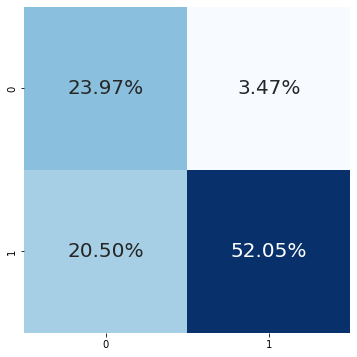

In [41]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(group_names).reshape(2,2)

mat = confusion_matrix(df_result.y_test, df_result.prediction.round())
ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(mat.T/317, square=True, annot=True, fmt='.2%', cbar=False, cmap="Blues", annot_kws={"size":20})
#plt.xlabel(' \nTrue Label', fontsize=15)
#plt.ylabel('Predicted Label\n ', fontsize=15)
#ax.set_xticklabels(["CN", "MCI/AD"], size=17)
#ax.set_yticklabels(["CN", "MCI/AD"], size=17)

In [42]:
3.47/(3.47+52.05)

0.06250000000000001

[Text(0, 0.5, 'CN'), Text(0, 1.5, 'MCI/AD')]

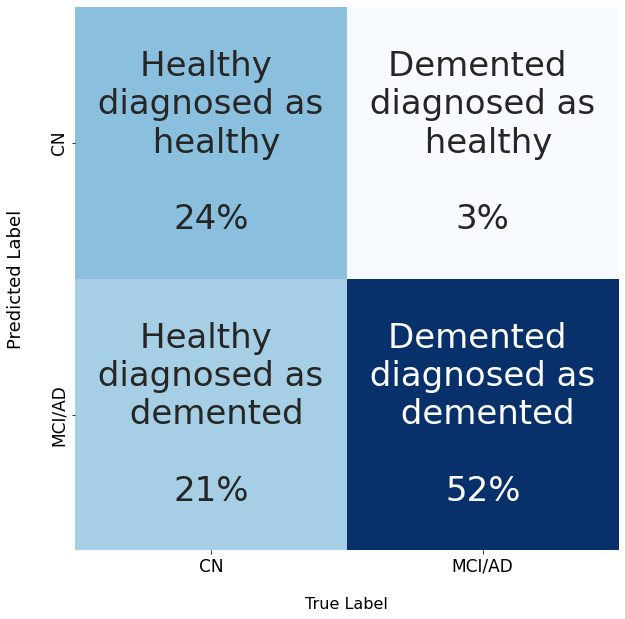

In [43]:
mat = confusion_matrix(df_result.y_test, df_result.prediction.round())
group_names = ["Healthy \n diagnosed as \n healthy\n ","Demented \n diagnosed as \n healthy\n ","Healthy \n diagnosed as \n demented\n ","Demented \n diagnosed as \n demented\n "]
group_percentages = ["{0:.0%}".format(value) for value in
                     mat.flatten()/np.sum(mat)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,[group_percentages[0], group_percentages[2], group_percentages[1],group_percentages[3]])]
labels = np.asarray(labels).reshape(2,2)
#labels = np.asarray(group_names).reshape(2,2)



ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(mat.T/317, square=True, annot=labels, fmt='', cbar=False, cmap="Blues", annot_kws={"size":34})

plt.xlabel(' \nTrue Label', fontsize=16)
plt.ylabel('Predicted Label\n ', fontsize=18)
ax.set_xticklabels(["CN", "MCI/AD"], size=17)
ax.set_yticklabels(["CN", "MCI/AD"], size=17)

In [44]:
mat/np.sum(mat)

array([[0.23974763, 0.20504732],
       [0.03470032, 0.52050473]])

In [45]:
mat.flatten()/np.sum(mat)

array([0.23974763, 0.20504732, 0.03470032, 0.52050473])

[Text(0, 0.5, 'CN'), Text(0, 1.5, 'MCI/AD')]

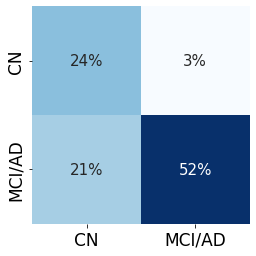

In [46]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(group_names).reshape(2,2)

mat = confusion_matrix(df_result.y_test, df_result.prediction.round())
ax = sns.heatmap(mat.T/317, square=True, annot=True, fmt='.0%', cbar=False, cmap="Blues", annot_kws={"size":15})
#plt.xlabel(' \nTrue Label', fontsize=15)
#plt.ylabel('Predicted Label\n ', fontsize=15)
ax.set_xticklabels(["CN", "MCI/AD"], size=17)
ax.set_yticklabels(["CN", "MCI/AD"], size=17)

[Text(0, 0.5, 'CN'), Text(0, 1.5, 'MCI/AD')]

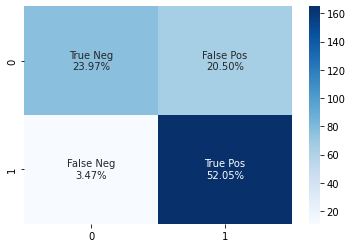

In [47]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     mat.flatten()/np.sum(mat)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mat, annot=labels, fmt="", cmap='Blues')
ax.set_xticklabels(["CN", "MCI/AD"], size=12)
ax.set_yticklabels(["CN", "MCI/AD"], size=12)

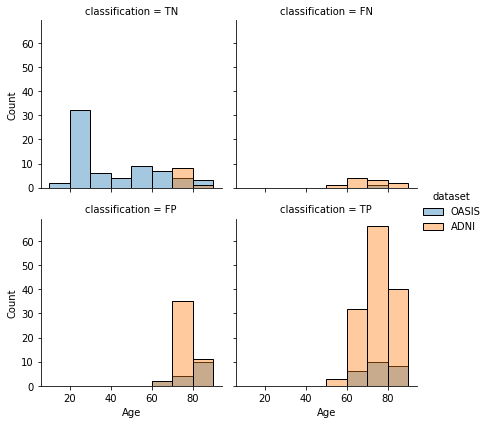

In [49]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="dataset", legend_out=True)
plot.map_dataframe(sns.histplot, x="Age", binrange=(10,90), binwidth=10, alpha=0.4)
plot.add_legend();

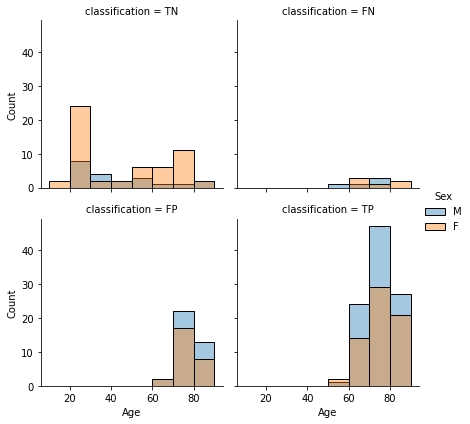

In [62]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="Sex", legend_out=True)
plot.map_dataframe(sns.histplot, x="Age", binrange=(10,90), binwidth=10, alpha=0.4)
plot.add_legend();

In [50]:
precision, recall, thresholds = precision_recall_curve(df_result["y_test"], df_result["y_pred"])

In [51]:
thresholds = np.append(thresholds, 1)

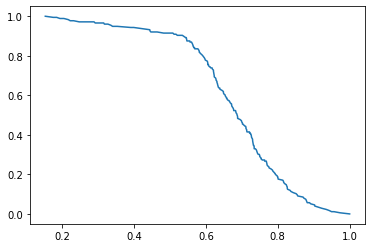

In [52]:
plt.plot(thresholds, recall)

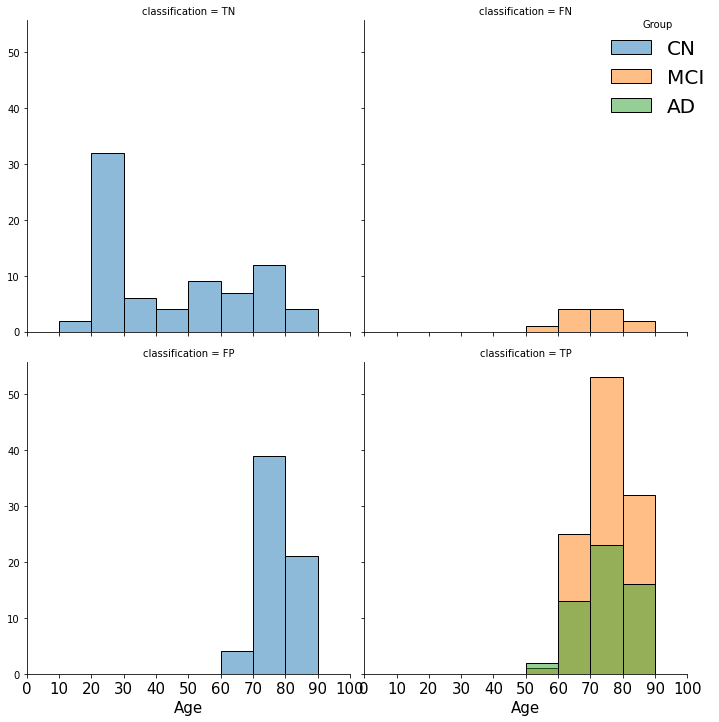

In [53]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="label", legend_out=True, height=5)
plot.map_dataframe(sns.histplot, x="Age", binrange=(10,90), binwidth=10, alpha=0.5)
plot.add_legend(fontsize=20, title= "Group", bbox_to_anchor= (0.9,0.9))
plot.set_xticklabels(fontsize=15)
plot.set_ylabels(fontsize=15)
plot.set_xlabels(fontsize=15)

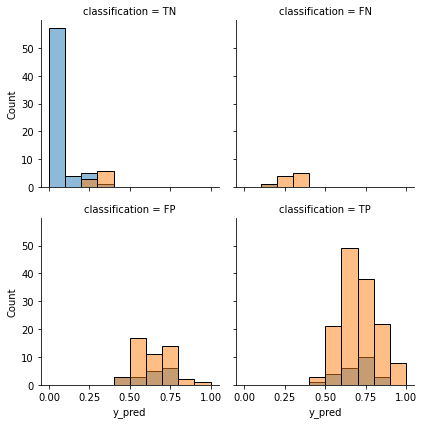

In [54]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="dataset")#, hue="dataset", legend_out=True)
plot.map_dataframe(sns.histplot, x="y_pred", binrange=(0,1), binwidth=0.1, alpha=0.5);

In [55]:
df = df_result.copy()
df["orig_order"] = df.index
df.sort_values("y_pred", inplace=True)
df= df.reset_index(drop=True)
df["order"] = df.index
df.sort_values("orig_order", inplace=True)
df= df.reset_index(drop=True)
df.drop("orig_order", axis=1, inplace=True)
df


,ID,Age,label,y_test,y_pred,dataset,Sex,prediction,classification,order
0,OAS1_0145_MR1,34,CN,0,0.002277,OASIS,M,0.0,TN,29
1,OAS1_0019_MR1,89,CN,0,0.605508,OASIS,F,1.0,FP,145
2,OAS1_0372_MR1,59,CN,0,0.006064,OASIS,M,0.0,TN,40
3,OAS1_0018_MR1,39,CN,0,0.001319,OASIS,M,0.0,TN,24
4,OAS1_0266_MR1,51,CN,0,0.060436,OASIS,M,0.0,TN,53
...,...,...,...,...,...,...,...,...,...,...
312,099_S_0352,77,CN,0,0.554856,ADNI,F,1.0,FP,115
313,027_S_0116,79,MCI,1,0.217359,ADNI,M,0.0,FN,64
314,128_S_0740,72,AD,1,0.891688,ADNI,M,1.0,TP,307
315,021_S_0626,83,MCI,1,0.630802,ADNI,M,1.0,TP,165


<AxesSubplot:xlabel='label', ylabel='count'>

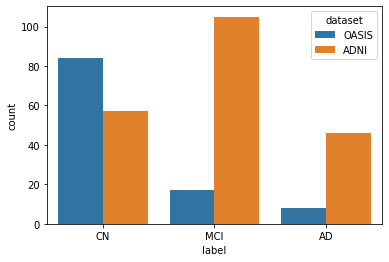

In [56]:
sns.countplot(data= df,  x="label", hue="dataset")

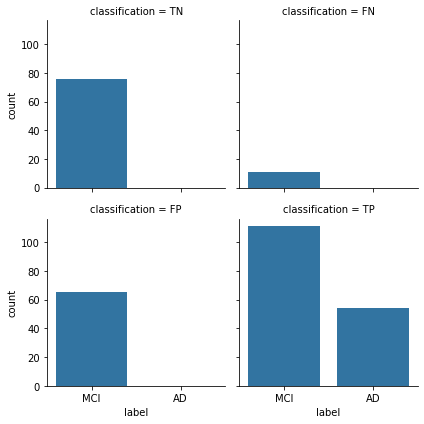

In [57]:
plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.countplot, x="label");

In [58]:
sys.path.append('../')
from preprocessing.getdata import *
IDs_o = df[df["dataset"]== "OASIS"]["ID"]
IDs_a = df[df["dataset"]== "ADNI"]["ID"]

imgs = get_slices_both(OASIS_IDs =IDs_o, ADNI_IDs =IDs_a, dim=2, m=90, normalize=True)
#imgs= get_slices(IDs_o, dim=2, m=90, normalize=False)
#imgs= get_slices_ADNI(IDs_a, dim=2, m=90, normalize=False)
imgs.shape

 47%|████▋     | 97/208 [00:19<00:21,  5.09it/s]


KeyboardInterrupt: 

In [ ]:
order= np.array(df["order"])
sort = order.argsort()
imgs_sorted= imgs[sort]

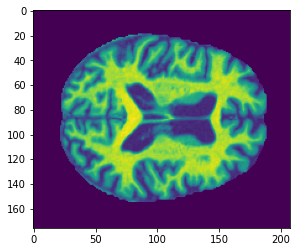

In [ ]:
#most confident CN
plt.imshow(imgs_sorted[284])

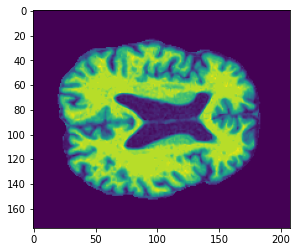

In [ ]:
#most confident AD
im = plt.imshow(imgs_sorted[-1])

In [ ]:
type(im)

matplotlib.image.AxesImage

In [ ]:
from matplotlib import animation


# generating gif out of slices of 3-dimensional numpy array
def generate_gif(numpy_3d_array, y_pred, path="test.gif"):
    fig = plt.figure()
    im = plt.imshow(numpy_3d_array[0, :, :],    # display first slice
                    animated=True,
                    cmap='Greys',               # color mapping
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1) # highest value in numpy_3d_array
    

    def init():
        im.set_data(numpy_3d_array[0, :, :])
        return im,

    def animate(i):
        im.set_array(numpy_3d_array[i, :, :])
        #plt.text(180,20, y_pred[i], fontsize=20)
        return im,

    # calling animation function of matplotlib
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=np.shape(numpy_3d_array)[0],  # amount of frames being animated
                                   interval=100,                       # update every x-milliseconds
                                   blit=True)
    anim.save(path)   # save as gif
    plt.show()

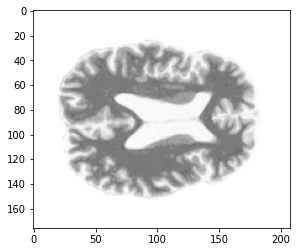

In [ ]:
os.makedirs("./gifs/", exist_ok=True)
generate_gif(imgs_sorted, y_pred=df["y_pred"], path="./gifs/"+file[:-4]+"final_model.gif")

In [ ]:
os.makedirs("../data/sorted_pngs/", exist_ok=True)
for i in range(imgs_sorted.shape[0]):
    plt.imsave(f"../data/sorted_pngs/img{i}.png", imgs_sorted[i], cmap="Greys")

In [ ]:
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>